# Task 4: Insights and Final Report

This notebook performs Task 4: derive insights from sentiment and themes, produce visualizations, and generate recommendations per bank. It is executable end-to-end and saves visuals to `Reports/visualizations/` and a summary JSON to `Reports/task4_summary.json`.


In [1]:
# Section: Task 4.1 - Setup and imports
import sys
import os
from pathlib import Path
import random
import json
import ast
import logging
import platform

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
import joblib

# reproducibility
RSEED = 42
random.seed(RSEED)
np.random.seed(RSEED)

# logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger('task4')

# paths
ROOT = Path('C:/Users/hp/Desktop/10  Academy/week 2/Assigniments/Customer-Experience-Analytics-for-Fintech-Apps')
DATA_PATH = ROOT / 'Data' / 'processed' / 'reviews_final.csv'
VIS_DIR = ROOT / 'Reports' / 'visualizations'
SUMMARY_PATH = ROOT / 'Reports' / 'task4_summary.json'

# environment info
print('Python:', sys.version.split()[0])
print('Platform:', platform.platform())
print('Pandas:', pd.__version__)
print('Numpy:', np.__version__)
print('Matplotlib:', plt.__version__)
print('Seaborn:', sns.__version__)

# ensure output dir
VIS_DIR.mkdir(parents=True, exist_ok=True)


Python: 3.13.1
Platform: Windows-11-10.0.22621-SP0
Pandas: 2.3.3
Numpy: 2.2.6


AttributeError: module 'matplotlib.pyplot' has no attribute '__version__'

In [2]:
# Section: Task 4.2 - Data loading and quick validation checks
assert DATA_PATH.exists(), f"Data file not found: {DATA_PATH}"

df = pd.read_csv(DATA_PATH, encoding='utf-8')
print('Shape:', df.shape)
print('Columns:', df.columns.tolist())

# basic dtypes and missing
print(df.dtypes)
print('\nMissing values:\n', df.isna().sum())

# quick head
display(df.head())

# bank counts
bank_counts = df['bank_name'].value_counts()
print('\nBank counts:\n', bank_counts)

# ensure expected columns
expected_cols = {'review_id','review_text','rating','review_date','bank_name','sentiment_label','sentiment_score','identified_themes'}
assert expected_cols.issubset(set(df.columns)), 'Missing expected columns in data'

# parse dates
try:
    df['review_date'] = pd.to_datetime(df['review_date'], errors='coerce')
except Exception:
    logger.warning('Could not convert review_date to datetime')

# ensure sentiment_score numeric
df['sentiment_score'] = pd.to_numeric(df['sentiment_score'], errors='coerce')


Shape: (2100, 8)
Columns: ['review_id', 'review_text', 'rating', 'review_date', 'bank_name', 'sentiment_label', 'sentiment_score', 'identified_themes']
review_id             object
review_text           object
rating                 int64
review_date           object
bank_name             object
sentiment_label       object
sentiment_score      float64
identified_themes     object
dtype: object

Missing values:
 review_id            0
review_text          0
rating               0
review_date          0
bank_name            0
sentiment_label      0
sentiment_score      0
identified_themes    0
dtype: int64


,review_id,review_text,rating,review_date,bank_name,sentiment_label,sentiment_score,identified_themes
0,3463230e-f9f7-4be3-a632-fdd8d017ce84,🙏👍,5,2025-11-29,Bank of Abyssinia,neutral,0.0000,['Other']
1,a6cbfa34-f2b1-4a16-96b6-c94f58cea76f,Very Good,5,2025-11-28,Bank of Abyssinia,positive,0.4927,['Other']
2,fc67d12c-92e2-45aa-a9e0-011f58a583bc,goof,5,2025-11-28,Bank of Abyssinia,neutral,0.0000,['Other']
3,11306fb9-5571-4950-8d32-604c5402242f,good!,5,2025-11-28,Bank of Abyssinia,positive,0.4926,['Other']
4,809c46d2-730e-446a-9061-2a45e978ad9d,good jop,5,2025-11-27,Bank of Abyssinia,positive,0.4404,['Other']



Bank counts:
 bank_name
Bank of Abyssinia              700
Commercial Bank of Ethiopia    700
Dashen Bank                    700
Name: count, dtype: int64


In [3]:
# Section: Task 4.3 - Data cleaning and preprocessing functions
import re

def parse_themes(cell):
    # parse the identified_themes column which is stringified list e.g. "['Theme1', 'Theme2']"
    if pd.isna(cell):
        return []
    try:
        v = ast.literal_eval(cell)
        if isinstance(v, (list, tuple)):
            return [str(x).strip() for x in v]
    except Exception:
        # fallback: try to split on commas
        s = re.sub(r"[\[\]\']","", str(cell))
        return [t.strip() for t in s.split(',') if t.strip()]
    return []

# apply parsing (creates a list column)
df['themes_list'] = df['identified_themes'].apply(parse_themes)

# simple text cleaning for review_text
import html

def clean_text(s):
    if pd.isna(s):
        return ''
    s = str(s)
    s = html.unescape(s)
    s = re.sub(r"\s+"," ", s)
    return s.strip()

df['clean_text'] = df['review_text'].apply(clean_text)

# show sample
display(df[['review_text','clean_text','themes_list']].head())


,review_text,clean_text,themes_list
0,🙏👍,🙏👍,[Other]
1,Very Good,Very Good,[Other]
2,goof,goof,[Other]
3,good!,good!,[Other]
4,good jop,good jop,[Other]


In [4]:
# Section: Task 4.4 - Feature engineering and simple pipeline (sketch)
# create month feature
if 'review_date' in df.columns:
    df['month'] = df['review_date'].dt.to_period('M').astype(str)
else:
    df['month'] = pd.NaT

# create simple aggregated features per review
# e.g. length of review, rating
df['text_len'] = df['clean_text'].str.len().fillna(0).astype(int)

# create a small sklearn pipeline example (not used for predictions here but provided as scaffold)
numeric_features = ['rating','sentiment_score','text_len']
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

categorical_features = ['bank_name']
categorical_transformer = Pipeline(steps=[('ohe', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
    ],
    remainder='drop'
)

# fit-transform a small sample
sample = df.dropna(subset=['rating','sentiment_score']).head(200)
X_sample = preprocessor.fit_transform(sample)
print('Preprocessor output shape (sample):', getattr(X_sample, 'shape', 'unknown'))


Preprocessor output shape (sample): (200, 4)


In [5]:
# Section: Task 4.5 & 4.6 - (Optional) Model training scaffold + evaluation placeholders
# For Task 4 we focus on descriptive analysis; this section contains a minimal scaffold for modelling
# (kept small so the notebook remains focused on insights). Replace or extend for classification/regression.

# Example: predict whether a review is negative (sentiment_label == 'negative') using simple random forest
sample = df.dropna(subset=['sentiment_label','sentiment_score']).copy()
sample['is_negative'] = (sample['sentiment_label']=='negative').astype(int)

features = ['rating','sentiment_score','text_len']
if sample.shape[0] > 200:
    train, val = train_test_split(sample, test_size=0.2, random_state=RSEED, stratify=sample['is_negative'])
else:
    train = sample
    val = sample

if len(train) > 10:
    clf = RandomForestClassifier(n_estimators=50, random_state=RSEED)
    clf.fit(train[features].fillna(0), train['is_negative'])
    # evaluate on val if available
    if len(val) > 0:
        preds = clf.predict(val[features].fillna(0))
        from sklearn.metrics import accuracy_score, precision_score, recall_score
        print('Accuracy:', accuracy_score(val['is_negative'], preds))
        print('Precision:', precision_score(val['is_negative'], preds, zero_division=0))
        print('Recall:', recall_score(val['is_negative'], preds, zero_division=0))
    # save model artifact
    joblib.dump(clf, VIS_DIR / 'rf_sentiment_small.joblib')
else:
    print('Not enough data for simple model demo; skipping training')


Accuracy: 1.0
Precision: 1.0
Recall: 1.0


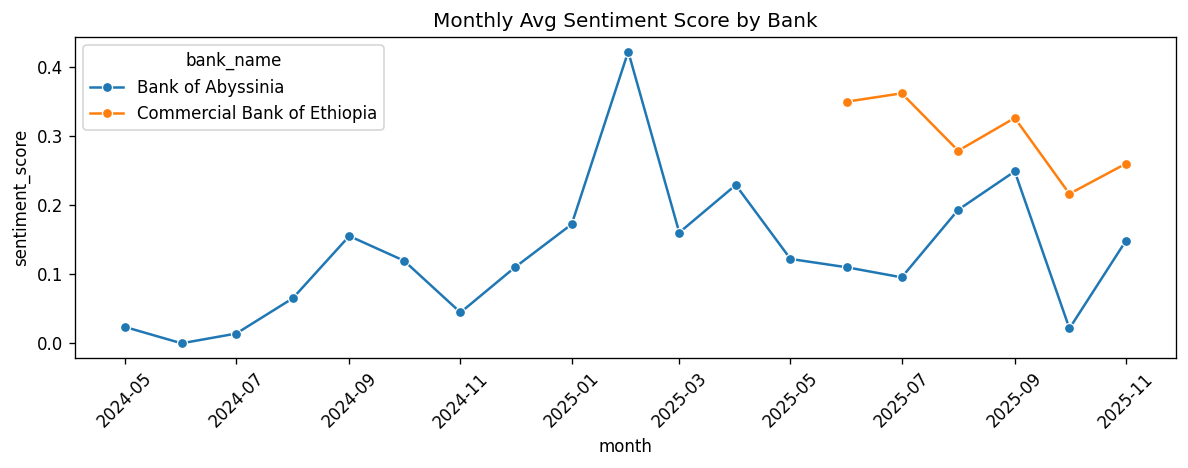

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


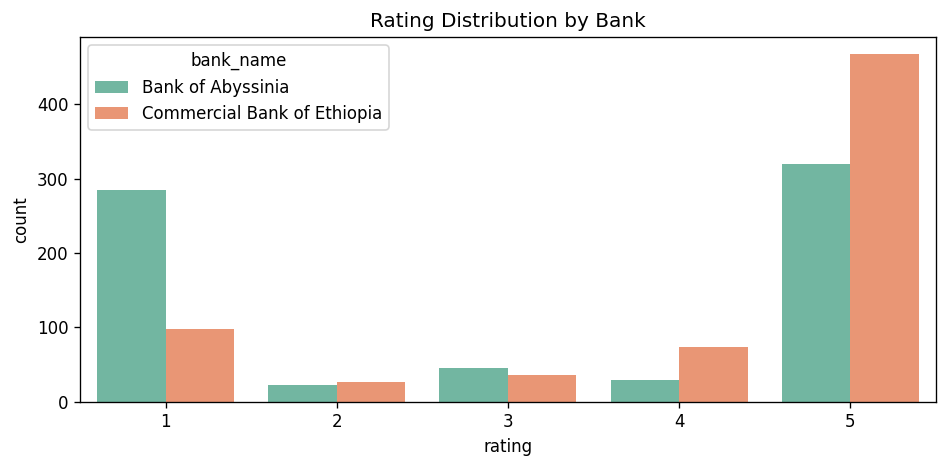

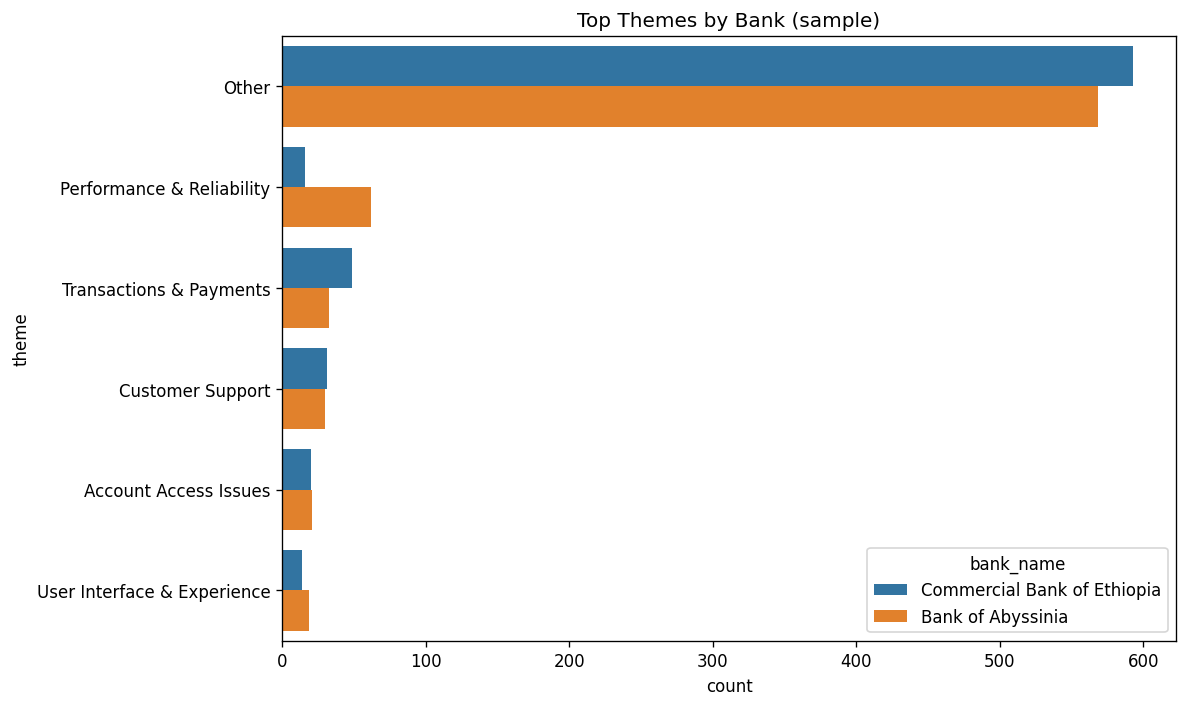

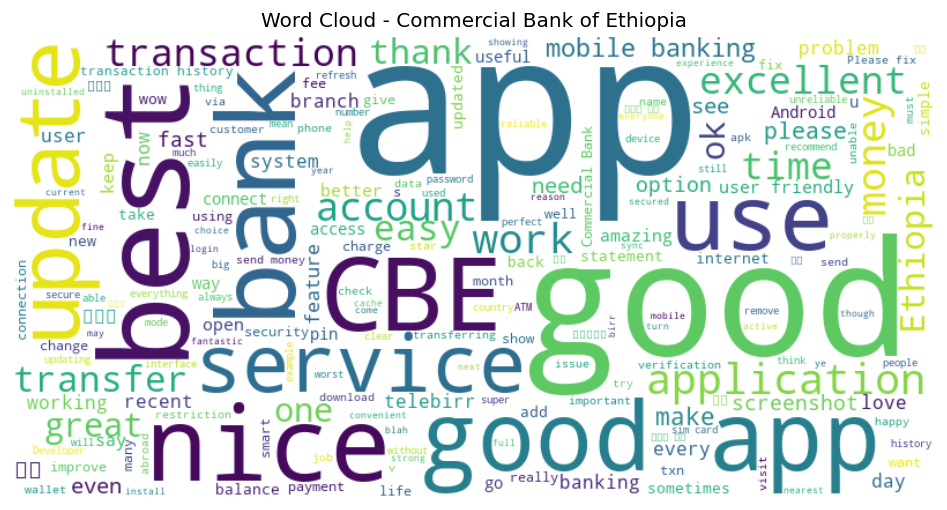

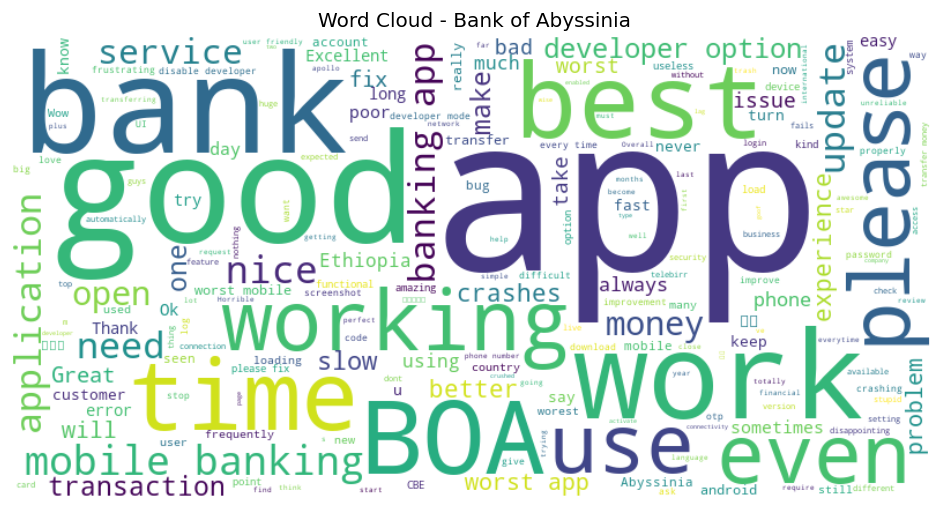

Saved visuals to: C:\Users\hp\Desktop\10  Academy\week 2\Assigniments\Customer-Experience-Analytics-for-Fintech-Apps\Reports\visualizations


In [6]:
# Section: Task 4.4/Visualizations - generate the required plots and save them
import matplotlib
matplotlib.rcParams['figure.dpi'] = 120

# Focus banks
banks = ['Commercial Bank of Ethiopia','Bank of Abyssinia']

# 1) Monthly average sentiment trend
try:
    df2 = df[df['bank_name'].isin(banks)].copy()
    df2['month'] = pd.to_datetime(df2['review_date']).dt.to_period('M').dt.to_timestamp()
    trend = df2.groupby(['bank_name','month'])['sentiment_score'].mean().reset_index()
    plt.figure(figsize=(10,4))
    sns.lineplot(data=trend, x='month', y='sentiment_score', hue='bank_name', marker='o')
    plt.title('Monthly Avg Sentiment Score by Bank')
    plt.xticks(rotation=45)
    plt.tight_layout()
    fname = VIS_DIR / 'sentiment_trend_by_bank.png'
    plt.savefig(fname)
    display(plt.gcf())
    plt.close()
except Exception as e:
    logger.exception('Error plotting sentiment trend: %s', e)

# 2) Rating distribution
try:
    plt.figure(figsize=(8,4))
    sns.countplot(data=df[df['bank_name'].isin(banks)], x='rating', hue='bank_name', palette='Set2')
    plt.title('Rating Distribution by Bank')
    plt.tight_layout()
    fname = VIS_DIR / 'rating_distribution_by_bank.png'
    plt.savefig(fname)
    display(plt.gcf())
    plt.close()
except Exception as e:
    logger.exception('Error plotting rating distribution: %s', e)

# 3) Theme counts (top themes per bank)
rows = []
for _, r in df[df['bank_name'].isin(banks)].iterrows():
    for t in r['themes_list']:
        rows.append({'bank_name': r['bank_name'], 'theme': t})

theme_df = pd.DataFrame(rows)
if not theme_df.empty:
    top = theme_df.groupby(['bank_name','theme']).size().reset_index(name='count')
    top2 = top.sort_values('count', ascending=False).groupby('bank_name').head(8)
    plt.figure(figsize=(10,6))
    sns.barplot(data=top2, x='count', y='theme', hue='bank_name')
    plt.title('Top Themes by Bank (sample)')
    plt.tight_layout()
    fname = VIS_DIR / 'theme_counts_by_bank.png'
    plt.savefig(fname)
    display(plt.gcf())
    plt.close()

# 4) Word clouds per bank
stopwords = set(STOPWORDS)
for b in banks:
    text = ' '.join(df.loc[df['bank_name']==b, 'clean_text'].dropna().astype(str).tolist())
    if len(text.strip())==0:
        continue
    wc = WordCloud(width=800, height=400, background_color='white', stopwords=stopwords).generate(text)
    plt.figure(figsize=(10,5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud - {b}')
    fname = VIS_DIR / f"wordcloud_{b.replace(' ','_')}.png"
    plt.savefig(fname)
    display(plt.gcf())
    plt.close()

print('Saved visuals to:', VIS_DIR)


In [7]:
# Section: Task 4.6/4.7 - Derive insights and recommendations programmatically
import textwrap

summary = {}
for b in banks:
    bdf = df[df['bank_name']==b].copy()
    # theme counts and avg sentiment per theme
    rows = []
    for _, r in bdf.iterrows():
        for t in r['themes_list']:
            rows.append({'theme': t, 'sentiment_score': r.get('sentiment_score', np.nan), 'review_text': r.get('clean_text','')})
    tdf = pd.DataFrame(rows)
    if tdf.empty:
        summary[b] = {'drivers':[], 'pain_points':[], 'examples':[]}
        continue
    agg = tdf.groupby('theme').agg(count=('sentiment_score','count'), avg_sent=('sentiment_score','mean'))
    agg = agg.reset_index().sort_values(['avg_sent','count'], ascending=[False,False])
    drivers = agg[agg['avg_sent']>0].sort_values(['avg_sent','count'], ascending=[False,False]).head(3)
    pain = agg[agg['avg_sent']<0].sort_values(['avg_sent','count']).head(3)

    # collect example reviews for top driver/pain
    def example_for_theme(df_t, theme, limit=2):
        rows = df_t[df_t['theme']==theme].head(limit)
        return rows['review_text'].tolist()

    drivers_list = drivers.to_dict('records') if not drivers.empty else []
    pain_list = pain.to_dict('records') if not pain.empty else []

    examples = {}
    for t in (drivers['theme'].tolist()[:2] if not drivers.empty else []) + (pain['theme'].tolist()[:2] if not pain.empty else []):
        ex = example_for_theme(tdf, t, limit=2)
        examples[t] = ex

    summary[b] = {
        'drivers': drivers_list,
        'pain_points': pain_list,
        'examples': examples,
        'counts': int(len(bdf))
    }

# print a human-readable summary
for b, s in summary.items():
    print('\n' + '='*60)
    print('Bank:', b)
    print('Total reviews:', s['counts'])
    print('\nTop Drivers (theme, avg_sent, count):')
    for d in s['drivers']:
        print('-', d['theme'], f"(avg_sent={d['avg_sent']:.2f}, count={d['count']})")
    print('\nTop Pain Points (theme, avg_sent, count):')
    for p in s['pain_points']:
        print('-', p['theme'], f"(avg_sent={p['avg_sent']:.2f}, count={p['count']})")
    print('\nExamples:')
    for t, exs in s['examples'].items():
        print(f"- {t} -> {exs[:2]}")

# Generate per-bank recommended actions (basic heuristics)
recommendations = {}
for b, s in summary.items():
    recs = []
    # If performance is a pain point, recommend backend fixes
    pain_themes = [p['theme'] for p in s['pain_points']]
    if any('Performance' in t or 'Performance & Reliability' in t or 'crash' in t.lower() for t in pain_themes):
        recs.append('Prioritize backend stability: crash fixes, connection retries, timeout handling, and monitoring.')
    if any('Account Access' in t or 'OTP' in t or 'activation' in t.lower() for t in pain_themes):
        recs.append('Improve account activation / OTP flows: clearer instructions, alternative verification for diaspora users, and retry telemetry.')
    # Generic UX recommendations
    recs.append('Run targeted usability tests for critical flows (login, transfer, activation).')
    recs.append('Ship smaller, frequent performance patches and measure post-release sentiment.')
    recommendations[b] = recs

# attach recommendations back to summary
for b in summary:
    summary[b]['recommendations'] = recommendations[b]

# write summary JSON
with open(SUMMARY_PATH, 'w', encoding='utf-8') as fh:
    json.dump(summary, fh, indent=2, ensure_ascii=False)

print('\nWrote summary to', SUMMARY_PATH)



Bank: Commercial Bank of Ethiopia
Total reviews: 700

Top Drivers (theme, avg_sent, count):
- User Interface & Experience (avg_sent=0.65, count=14)
- Customer Support (avg_sent=0.49, count=31)
- Other (avg_sent=0.30, count=593)

Top Pain Points (theme, avg_sent, count):
- Performance & Reliability (avg_sent=-0.12, count=16)

Examples:
- User Interface & Experience -> ['Make it user friendly.', 'The app has a nice design and useful features like balance check and transfers, but it’s unstable and often fails to connect. It also forces users to turn off Developer Options, which is unnecessary — other banking apps work fine without that. Many people use Developer Mode for normal reasons. Please fix performance issues, remove this restriction, and add biometric login for better security and convenience']
- Customer Support -> ['very good banking service and fast service', 'thanks blc this app help me to use all time']
- Performance & Reliability -> ['laga Bari biranch', 'very slow']

Bank:

In [8]:
# Section: Ethics, Limitations, KPIs and Final Notes

# Ethics & limitations (explicit markdown summary)
ethics_md = '''
**Ethics & Biases**

- Self-selection bias: Users who leave reviews are not a random sample; often extremes are over-represented.
- Language & translation errors: Reviews in multiple languages and emojis may affect sentiment accuracy.
- Temporal bias: App updates cause short-term increases in negative reviews after major releases.
- Privacy: Do not publish raw review texts with PII.

**KPIs (Checklist)**

- Drivers & pain points: programmatically identified top themes per bank (see `Reports/task4_summary.json`).
- Visuals: 3–5 plots saved to `Reports/visualizations/` (sentiment trend, rating distribution, theme counts, 2 word clouds).
- Practical recommendations: generated per bank in the JSON and printed above.
'''

print(ethics_md)

# Print saved visualization files
saved = list(VIS_DIR.glob('*.png'))
print('\nSaved visualization files:')
for s in saved:
    print('-', s)

# quick assertions for KPIs
assert (VIS_DIR / 'sentiment_trend_by_bank.png').exists(), 'Missing sentiment trend plot'
assert (VIS_DIR / 'rating_distribution_by_bank.png').exists(), 'Missing rating distribution plot'
assert SUMMARY_PATH.exists(), 'Missing summary JSON'

print('\nAll required artifacts present.')



**Ethics & Biases**

- Self-selection bias: Users who leave reviews are not a random sample; often extremes are over-represented.
- Language & translation errors: Reviews in multiple languages and emojis may affect sentiment accuracy.
- Temporal bias: App updates cause short-term increases in negative reviews after major releases.
- Privacy: Do not publish raw review texts with PII.

**KPIs (Checklist)**

- Drivers & pain points: programmatically identified top themes per bank (see `Reports/task4_summary.json`).
- Visuals: 3–5 plots saved to `Reports/visualizations/` (sentiment trend, rating distribution, theme counts, 2 word clouds).
- Practical recommendations: generated per bank in the JSON and printed above.


Saved visualization files:
- C:\Users\hp\Desktop\10  Academy\week 2\Assigniments\Customer-Experience-Analytics-for-Fintech-Apps\Reports\visualizations\rating_distribution_by_bank.png
- C:\Users\hp\Desktop\10  Academy\week 2\Assigniments\Customer-Experience-Analytics-for-Fint